Data has been recorded on an android phone attached to the dashboard of the car. Data was collected while driving the car on city roads in mild traffic. The parameters recorded are : Longitude, Latitude, Speed, Distance, Time, Acc X, Acc Y, Acc Z, Heading, gyro_x, gyro_y, gyro_z (Acc - Accelerometer, Gyro - Gyroscope).

🚓
Cluster driving segments (windows) based on sensor patterns like gyro and accelerometer   to distinguish normal vs aggressive driving styles — without using labels during clustering

In [63]:
#Importing necessary packages and modules

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
from google.colab import files
uploaded = files.upload()

Saving FinalDatasetCsv.csv to FinalDatasetCsv (1).csv


In [66]:
df=pd.read_csv("FinalDatasetCsv.csv")

In [67]:
df.head()

,Acc X,Acc Y,Acc Z,gyro_x,gyro_y,gyro_z,label
0,0.046402,-0.137178,-0.282934,-0.036306,-0.008226,-0.023416,0
1,-0.136978,0.365242,0.108889,0.035776,-0.009448,0.009570,0
2,-0.045355,-0.103340,-0.534985,-0.011871,-0.027774,0.003462,0
3,0.242089,0.072761,-0.350396,-0.017980,0.002769,-0.005091,0
4,-0.230234,0.011765,-0.494085,0.011342,0.003380,0.006516,0


In [ ]:
df.label.unique()  #class 0 and 1

array([0, 1])

'0' represents normal driving behavior while '1' represents aggressive driving behavior as per this dataset  Phone sensor data while driving a car  in kaggle https://www.kaggle.com/datasets/shardulnazirkar1/phone-sensor-data-while-driving-a-car. But this is of no use since i will treat this is as completely unsupervised ,And the labeling is as per datset ,Unsupervised Agglomerative clustering will create two clusters from scratch with no relation to previous labels

In [ ]:
 df['label'].value_counts()

,count
label,
1,8444
0,5805


In [ ]:
df.isna().sum() #checked no null values

In [ ]:
df.shape

(14249, 7)

FEATURE ENGINERRING (WINDOWING)

In [68]:
# I am  dividing  the continuous sensor readings into small time windows.
# Each window (~200 samples) ≈ few seconds of driving.

#dataset has approx 14,000 rows, this means i will  end up with about 14,000 ÷ 200 = 70 segments.

#disregarding label column as unsupervised

window = 200

df['window_id'] = df.index // window  #rounding  down to the nearest whole number

sensor_cols = ['Acc X', 'Acc Y', 'Acc Z', 'gyro_x', 'gyro_y', 'gyro_z']  # capturing data from sensory columns

#Acceleration along three axes (Acc X, Acc Y, Acc Z)

#Rotation along three axes (gyro_x, gyro_y, gyro_z)



In [69]:
feature_df = (
    df.groupby('window_id')[sensor_cols]
      .agg(['mean','std','max','min'])
      .reset_index(drop=True)
)
feature_df.columns = ['_'.join(col) for col in feature_df.columns]

In [70]:
pd.set_option('display.max_columns', None)

In [71]:
feature_df.head()

,Acc X_mean,Acc X_std,Acc X_max,Acc X_min,Acc Y_mean,Acc Y_std,Acc Y_max,Acc Y_min,Acc Z_mean,Acc Z_std,Acc Z_max,Acc Z_min,gyro_x_mean,gyro_x_std,gyro_x_max,gyro_x_min,gyro_y_mean,gyro_y_std,gyro_y_max,gyro_y_min,gyro_z_mean,gyro_z_std,gyro_z_max,gyro_z_min
0,-0.000728,0.618896,2.686953,-2.291411,0.185980,0.846106,3.579076,-4.791968,-0.143113,1.635150,8.410082,-6.439154,-0.002372,0.155736,0.954518,-0.631899,-0.007218,0.042987,0.123721,-0.220197,-0.003841,0.051740,0.220930,-0.220726
1,-0.109304,1.478361,3.868440,-6.051202,0.067410,1.026705,3.539915,-3.586441,0.532547,2.087541,8.913069,-4.844684,0.016424,0.176643,0.665578,-0.521944,-0.005508,0.104416,0.265441,-0.265401,-0.011517,0.091745,0.272242,-0.323351
2,-0.296612,1.450496,4.307752,-3.426127,0.219299,1.114638,4.294948,-2.334550,0.074565,2.890959,9.668015,-12.094388,-0.016508,0.199964,0.734606,-0.664275,0.009162,0.086940,0.272161,-0.197595,0.000795,0.086425,0.233758,-0.207287
3,0.121155,1.183936,5.338616,-5.959079,0.182373,0.911577,3.217027,-4.339564,-0.049040,1.886630,9.882672,-4.952339,0.004531,0.127035,0.457273,-0.597080,-0.088286,0.116764,0.172590,-0.432778,0.002493,0.075120,0.385863,-0.266541
4,-0.092178,1.151763,2.857849,-3.260219,0.211681,0.899984,3.237454,-3.361013,-0.073468,1.824690,5.251144,-7.670261,-0.003875,0.163966,0.466436,-0.936721,0.013075,0.065860,0.253224,-0.175603,-0.010164,0.075051,0.258192,-0.256156


 Feature Engineering Magnitude

In [72]:
# Combining X, Y, Z into total vibration/rotation strength using Euclidean formula
df['acc_mag']  = np.sqrt(df['Acc X']**2 + df['Acc Y']**2 + df['Acc Z']**2)
df['gyro_mag'] = np.sqrt(df['gyro_x']**2 + df['gyro_y']**2 + df['gyro_z']**2)

Acc X → left-right motion

Acc Y → forward-backward motion

Acc Z → up-down bumps


gyro_x → pitching (nose up/down)

gyro_y → rolling (side tilt)

gyro_z → yawing (turns)


So now, instead of juggling 6 signals, I have 2

acc_mag → total vibration per moment

gyro_mag → total rotation per moment

I am using Euclidean norm  which gives the total vibration energy per reading (like the combined force the car is feeling).

In [73]:
#Summarizing magnitudes per window

mag_feats = (
    df.groupby('window_id')[['acc_mag','gyro_mag']]
      .mean()
      .rename(columns={'acc_mag':'acc_mag_mean','gyro_mag':'gyro_mag_mean'})
      .reset_index(drop=True)
)

In [75]:
mag_feats.shape #14000/200 apprx

(72, 2)

In [76]:
df.head(400)

,Acc X,Acc Y,Acc Z,gyro_x,gyro_y,gyro_z,label,window_id,acc_mag,gyro_mag
0,0.046402,-0.137178,-0.282934,-0.036306,-0.008226,-0.023416,0,0,0.317840,0.043979
1,-0.136978,0.365242,0.108889,0.035776,-0.009448,0.009570,0,0,0.404996,0.038220
2,-0.045355,-0.103340,-0.534985,-0.011871,-0.027774,0.003462,0,0,0.546759,0.030402
3,0.242089,0.072761,-0.350396,-0.017980,0.002769,-0.005091,0,0,0.432064,0.018891
4,-0.230234,0.011765,-0.494085,0.011342,0.003380,0.006516,0,0,0.545221,0.013510
...,...,...,...,...,...,...,...,...,...,...
395,2.893221,-1.276480,1.690267,0.296616,0.066299,-0.133983,1,1,3.585684,0.332157
396,1.558575,-1.889727,1.434857,0.060822,-0.129788,0.065770,1,1,2.838844,0.157702
397,1.189858,-0.378735,1.357018,-0.135877,-0.101078,0.054774,1,1,1.844099,0.177987
398,0.343079,-0.917026,-0.339183,-0.166420,-0.102300,0.131743,1,1,1.036188,0.235621


In [77]:
# Merging  magnitude features with statistical summaries
feature_df = pd.concat([feature_df, mag_feats], axis=1)

In [78]:
pd.set_option('display.max_columns', None)


In [79]:
feature_df.head() #previous 24 noe we have 26 columns including mean of acc and gyro

,Acc X_mean,Acc X_std,Acc X_max,Acc X_min,Acc Y_mean,Acc Y_std,Acc Y_max,Acc Y_min,Acc Z_mean,Acc Z_std,Acc Z_max,Acc Z_min,gyro_x_mean,gyro_x_std,gyro_x_max,gyro_x_min,gyro_y_mean,gyro_y_std,gyro_y_max,gyro_y_min,gyro_z_mean,gyro_z_std,gyro_z_max,gyro_z_min,acc_mag_mean,gyro_mag_mean
0,-0.000728,0.618896,2.686953,-2.291411,0.185980,0.846106,3.579076,-4.791968,-0.143113,1.635150,8.410082,-6.439154,-0.002372,0.155736,0.954518,-0.631899,-0.007218,0.042987,0.123721,-0.220197,-0.003841,0.051740,0.220930,-0.220726,1.204038,0.097708
1,-0.109304,1.478361,3.868440,-6.051202,0.067410,1.026705,3.539915,-3.586441,0.532547,2.087541,8.913069,-4.844684,0.016424,0.176643,0.665578,-0.521944,-0.005508,0.104416,0.265441,-0.265401,-0.011517,0.091745,0.272242,-0.323351,2.274673,0.193254
2,-0.296612,1.450496,4.307752,-3.426127,0.219299,1.114638,4.294948,-2.334550,0.074565,2.890959,9.668015,-12.094388,-0.016508,0.199964,0.734606,-0.664275,0.009162,0.086940,0.272161,-0.197595,0.000795,0.086425,0.233758,-0.207287,2.936924,0.195347
3,0.121155,1.183936,5.338616,-5.959079,0.182373,0.911577,3.217027,-4.339564,-0.049040,1.886630,9.882672,-4.952339,0.004531,0.127035,0.457273,-0.597080,-0.088286,0.116764,0.172590,-0.432778,0.002493,0.075120,0.385863,-0.266541,1.903680,0.167534
4,-0.092178,1.151763,2.857849,-3.260219,0.211681,0.899984,3.237454,-3.361013,-0.073468,1.824690,5.251144,-7.670261,-0.003875,0.163966,0.466436,-0.936721,0.013075,0.065860,0.253224,-0.175603,-0.010164,0.075051,0.258192,-0.256156,1.941377,0.153939


In [80]:
# Adding  a label for validation (most frequent label per window)between 0 AND 1
label_window = df.groupby('window_id')['label'].agg(lambda x: x.mode()[0]).reset_index(drop=True)
feature_df['label_window'] = label_window

In [81]:
feature_df.drop(columns=['label_window']).head()

,Acc X_mean,Acc X_std,Acc X_max,Acc X_min,Acc Y_mean,Acc Y_std,Acc Y_max,Acc Y_min,Acc Z_mean,Acc Z_std,Acc Z_max,Acc Z_min,gyro_x_mean,gyro_x_std,gyro_x_max,gyro_x_min,gyro_y_mean,gyro_y_std,gyro_y_max,gyro_y_min,gyro_z_mean,gyro_z_std,gyro_z_max,gyro_z_min,acc_mag_mean,gyro_mag_mean
0,-0.000728,0.618896,2.686953,-2.291411,0.185980,0.846106,3.579076,-4.791968,-0.143113,1.635150,8.410082,-6.439154,-0.002372,0.155736,0.954518,-0.631899,-0.007218,0.042987,0.123721,-0.220197,-0.003841,0.051740,0.220930,-0.220726,1.204038,0.097708
1,-0.109304,1.478361,3.868440,-6.051202,0.067410,1.026705,3.539915,-3.586441,0.532547,2.087541,8.913069,-4.844684,0.016424,0.176643,0.665578,-0.521944,-0.005508,0.104416,0.265441,-0.265401,-0.011517,0.091745,0.272242,-0.323351,2.274673,0.193254
2,-0.296612,1.450496,4.307752,-3.426127,0.219299,1.114638,4.294948,-2.334550,0.074565,2.890959,9.668015,-12.094388,-0.016508,0.199964,0.734606,-0.664275,0.009162,0.086940,0.272161,-0.197595,0.000795,0.086425,0.233758,-0.207287,2.936924,0.195347
3,0.121155,1.183936,5.338616,-5.959079,0.182373,0.911577,3.217027,-4.339564,-0.049040,1.886630,9.882672,-4.952339,0.004531,0.127035,0.457273,-0.597080,-0.088286,0.116764,0.172590,-0.432778,0.002493,0.075120,0.385863,-0.266541,1.903680,0.167534
4,-0.092178,1.151763,2.857849,-3.260219,0.211681,0.899984,3.237454,-3.361013,-0.073468,1.824690,5.251144,-7.670261,-0.003875,0.163966,0.466436,-0.936721,0.013075,0.065860,0.253224,-0.175603,-0.010164,0.075051,0.258192,-0.256156,1.941377,0.153939


In [82]:
# Scaling features so all are on equal footing (required for clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(feature_df.drop(columns=['label_window'])) # dropping label window

#Its a categorical label, not a continuous numeric feature.

#Scaling it would make no sense as  0 and 1 are classes, not magnitudes.

DENDOGRAM VISULIZATION FOR CLUSTERS

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


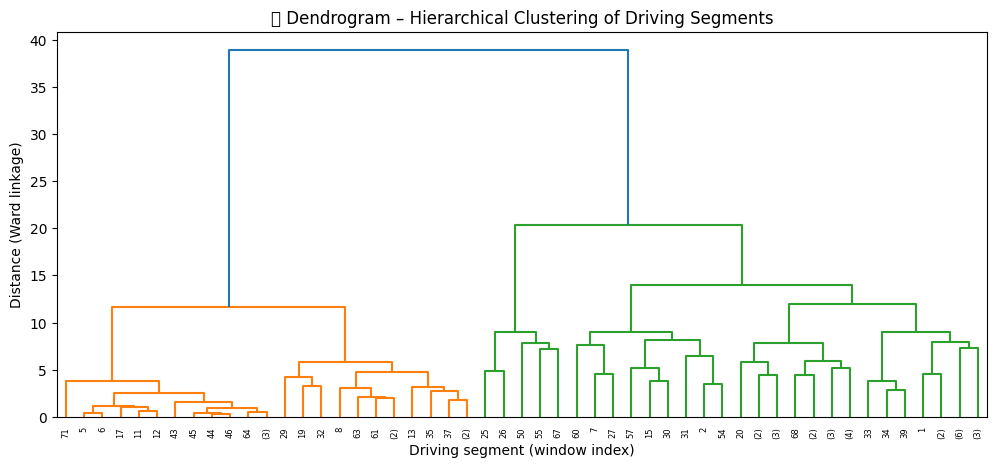

In [83]:
Z = linkage(X_scaled[:300], method='ward')  # sample subset for clarity I Can also try with complete  average ,single methods
#ward reduces total within cluster variance
plt.figure(figsize=(12, 5))
dendrogram(Z, truncate_mode='level', p=6) #Shows only top 6 merge levels
plt.title("📊 Dendrogram – Hierarchical Clustering of Driving Segments")
plt.xlabel("Driving segment (window index)")
plt.ylabel("Distance (Ward linkage)")
plt.show()

In [84]:
#The above dendogram is for exploration had it been unsupervised but since i droped columns of label

# And treated this as unsupervised to later compare with ground truth knowing there are two classes 0 and 1

Doing fitting

In [85]:
model = AgglomerativeClustering(n_clusters=2, linkage='ward')
feature_df['cluster'] = model.fit_predict(X_scaled)

In [86]:
from sklearn.metrics import silhouette_score

In [87]:
sil = silhouette_score(X_scaled, feature_df['cluster'])

print(f"Silhouette Score: {sil:.3f}" )

Silhouette Score: 0.336


Methods like DBSCAN or Gaussian Mixture Models (GMM) often perform better for noisy, continuous signals.

Silhouette checks cluster cohesion & separation,
while ARI checks alignment with ground truth labels (0 vs 1).

### 🚓 Clustering Evaluation Summary

The model achieved a **Silhouette Score of 0.336**, which measures how well the data points are naturally grouped into cohesive clusters and how distinct these clusters are from each other.  
Although the performance appears moderate, it’s important to note that the incoming data is **highly noisy**, being collected from smartphone sensors in real-world driving conditions.  
Accelerometers and gyroscopes are sensitive to external influences such as **road bumps, phone vibration, and orientation changes**, all of which can blur the distinction between driving styles.

Furthermore, **human driving behavior is not strictly binary**. Within a short time window, many drivers exhibit **mixed behavior** — for example, calm acceleration followed by sudden braking or sharp turns.  
These short-term transitions create overlap between what we classify as *“normal”* and *“aggressive”* driving.  
The chosen **window size (200 samples)** may also include multiple behavior patterns within one segment, making cluster boundaries less distinct.

The **Silhouette Score** ranges from **-1 to +1**, where higher values indicate more cohesive and well-separated clusters.  
A score around **0.3** suggests partial separation — the model is identifying meaningful structure in the data, but some overlap remains due to real-world noise and behavioral variation.

While the clustering results are not perfect, they still reveal **recognizable behavioral patterns** in the sensor data.  
Improvements can be made by refining the **feature space** (e.g., adding jerk, skewness, or frequency-based features), experimenting with different **window sizes**, or applying **noise filtering** techniques to better capture true driving dynamics.

> **Note:** The Adjusted Rand Index (ARI) was omitted since this is an *unsupervised analysis*.  
> ARI requires ground-truth labels and is not applicable when clustering is performed without label supervision.


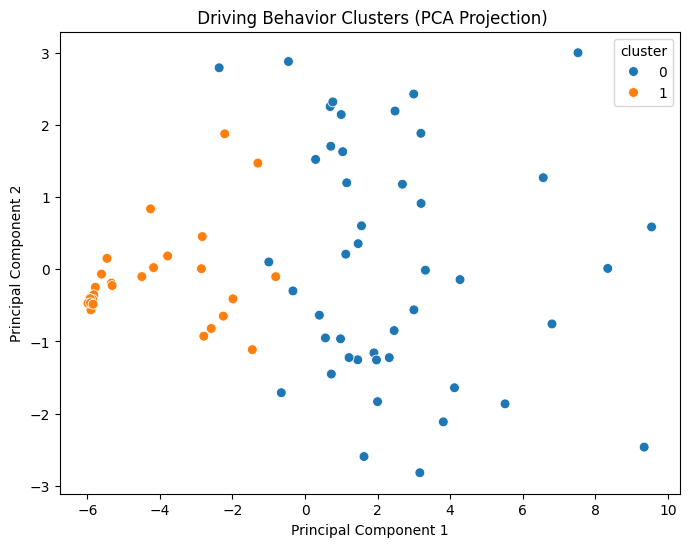

In [88]:
#High dimensional data reduced to two principal components for visualization

pca = PCA(n_components=2)
coords = pca.fit_transform(X_scaled)
feature_df[['PC1','PC2']] = pd.DataFrame(coords, index=feature_df.index)

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=feature_df, x='PC1', y='PC2',
    hue='cluster',
    s=50, palette='tab10'
)
plt.title(" Driving Behavior Clusters (PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [51]:
#feature_df = feature_df.loc[:, ~feature_df.columns.duplicated()]

In [91]:
# Computing  cluster-wise average metrics
summary = feature_df.groupby('cluster')[['acc_mag_mean', 'gyro_mag_mean']].mean().round(3)
print("\nCluster Summary (average motion intensity):")
print(summary)

# Calculating  overall mean acceleration
overall_acc_mean = summary['acc_mag_mean'].mean()# This second mean is across clusters both 0 and 1

# Interpreting  clusters
for cluster_id in summary.index:
    acc = summary.loc[cluster_id, 'acc_mag_mean']
    gyro = summary.loc[cluster_id, 'gyro_mag_mean']

    if acc < overall_acc_mean:
        behavior = "Normal Driving"
    else:
        behavior = "Aggressive Driving"

    print(f"Cluster {cluster_id}: {behavior} (acc={acc:.3f}, gyro={gyro:.3f})")


Cluster Summary (average motion intensity):
         acc_mag_mean  gyro_mag_mean
cluster                             
0               2.069          0.167
1               0.817          0.057
Cluster 0: Aggressive Driving (acc=2.069, gyro=0.167)
Cluster 1: Normal Driving (acc=0.817, gyro=0.057)


In [92]:
results_df = feature_df.copy() # mapping with cluster ids


mapping = {0: "Aggressive Driving", 1: "Normal Driving"}
results_df['Driving_Behavior'] = results_df['cluster'].map(mapping)

# Preview
results_df.head()

,Acc X_mean,Acc X_std,Acc X_max,Acc X_min,Acc Y_mean,Acc Y_std,Acc Y_max,Acc Y_min,Acc Z_mean,Acc Z_std,Acc Z_max,Acc Z_min,gyro_x_mean,gyro_x_std,gyro_x_max,gyro_x_min,gyro_y_mean,gyro_y_std,gyro_y_max,gyro_y_min,gyro_z_mean,gyro_z_std,gyro_z_max,gyro_z_min,acc_mag_mean,gyro_mag_mean,label_window,cluster,PC1,PC2,Driving_Behavior
0,-0.000728,0.618896,2.686953,-2.291411,0.185980,0.846106,3.579076,-4.791968,-0.143113,1.635150,8.410082,-6.439154,-0.002372,0.155736,0.954518,-0.631899,-0.007218,0.042987,0.123721,-0.220197,-0.003841,0.051740,0.220930,-0.220726,1.204038,0.097708,0,0,0.395840,-0.635707,Aggressive Driving
1,-0.109304,1.478361,3.868440,-6.051202,0.067410,1.026705,3.539915,-3.586441,0.532547,2.087541,8.913069,-4.844684,0.016424,0.176643,0.665578,-0.521944,-0.005508,0.104416,0.265441,-0.265401,-0.011517,0.091745,0.272242,-0.323351,2.274673,0.193254,1,0,2.996573,2.428832,Aggressive Driving
2,-0.296612,1.450496,4.307752,-3.426127,0.219299,1.114638,4.294948,-2.334550,0.074565,2.890959,9.668015,-12.094388,-0.016508,0.199964,0.734606,-0.664275,0.009162,0.086940,0.272161,-0.197595,0.000795,0.086425,0.233758,-0.207287,2.936924,0.195347,1,0,3.317298,-0.012383,Aggressive Driving
3,0.121155,1.183936,5.338616,-5.959079,0.182373,0.911577,3.217027,-4.339564,-0.049040,1.886630,9.882672,-4.952339,0.004531,0.127035,0.457273,-0.597080,-0.088286,0.116764,0.172590,-0.432778,0.002493,0.075120,0.385863,-0.266541,1.903680,0.167534,1,0,2.480158,2.193162,Aggressive Driving
4,-0.092178,1.151763,2.857849,-3.260219,0.211681,0.899984,3.237454,-3.361013,-0.073468,1.824690,5.251144,-7.670261,-0.003875,0.163966,0.466436,-0.936721,0.013075,0.065860,0.253224,-0.175603,-0.010164,0.075051,0.258192,-0.256156,1.941377,0.153939,0,0,1.451991,-1.253897,Aggressive Driving
